# Computation of scores for the test predictions

In [87]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
import pandas as pd

# Paths
gt_folder = "../dataset_test/labels"
raw_images_folder = "../dataset_test/images"
preprocessed_images_folder = "../dataset_test/preprocessed"
raw_pred_folder = "../dataset_test/raw_prediction"
post_pred_folder = "../dataset_test/post_prediction"

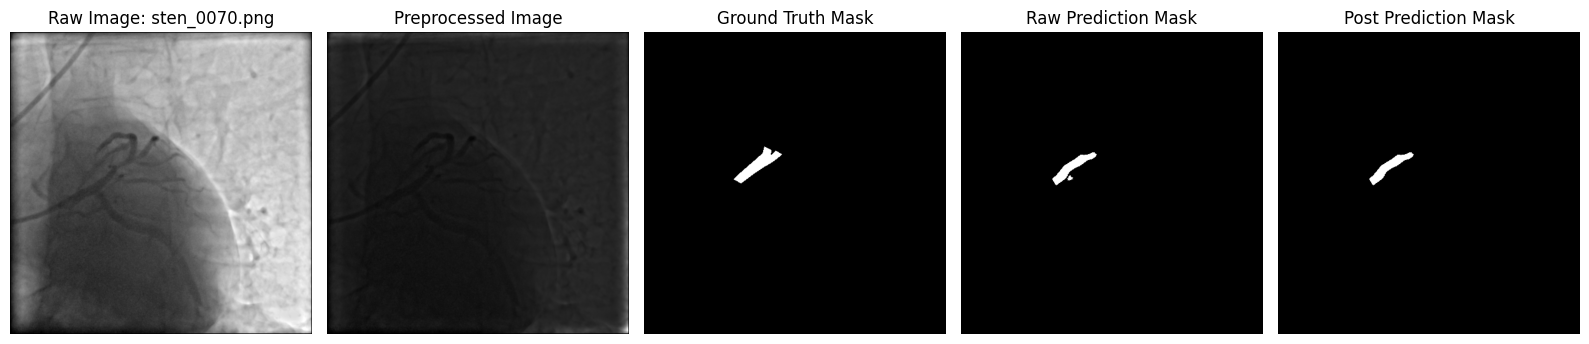

In [92]:
# Function to get the filename sten_XXXX_0000.png from the labelname sten_XXXX.png
def get_sten_filename(labelname):
    return labelname.replace(".png", "_0000.png")  

# Pick a random example to verify matching
random_gt_file = np.random.choice(os.listdir(gt_folder))
raw_image = get_sten_filename(random_gt_file)
preprocessed_image_file = get_sten_filename(random_gt_file)
raw_pred = random_gt_file
post_pred = random_gt_file

# Load example images
gt_mask = cv2.imread(os.path.join(gt_folder, random_gt_file), cv2.IMREAD_GRAYSCALE)
raw_image = cv2.imread(os.path.join(raw_images_folder, raw_image))  # Load raw image
processed_image = cv2.imread(os.path.join(preprocessed_images_folder, preprocessed_image_file))  # Load preprocessed image
raw_pred_mask = cv2.imread(os.path.join(raw_pred_folder, raw_pred), cv2.IMREAD_GRAYSCALE)
post_pred_mask = cv2.imread(os.path.join(post_pred_folder, post_pred), cv2.IMREAD_GRAYSCALE)

# Plot the example for debugging
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
axes[0].imshow(raw_image, cmap="gray")
axes[0].set_title(f"Raw Image: {random_gt_file}")
axes[0].axis("off")
axes[1].imshow(processed_image, cmap="gray")
axes[1].set_title("Preprocessed Image")
axes[1].axis("off")
axes[2].imshow(gt_mask, cmap="gray")
axes[2].set_title("Ground Truth Mask")
axes[2].axis("off")
axes[3].imshow(raw_pred_mask, cmap="gray")
axes[3].set_title("Raw Prediction Mask")
axes[3].axis("off")
axes[4].imshow(post_pred_mask, cmap="gray")
axes[4].set_title("Post Prediction Mask")
axes[4].axis("off")
plt.tight_layout()
plt.show()

In [93]:
# Function to compute IoU and Dice Score
def compute_iou_dice(gt_mask, pred_mask):
    """Compute IoU and Dice Score between GT and predictions."""
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union != 0 else 0.0
    dice = (2 * intersection) / (gt_mask.sum() + pred_mask.sum()) if (gt_mask.sum() + pred_mask.sum()) != 0 else 0.0
    return iou, dice

# Function to compute evaluation metrics
def compute_metrics(gt_filename):
    """Compute Precision, Recall, and F1 Score between GT and predictions."""
    
    # Construct file paths
    gt_mask = cv2.imread(os.path.join(gt_folder, gt_filename), cv2.IMREAD_GRAYSCALE)
    raw_pred_mask = cv2.imread(os.path.join(raw_pred_folder, gt_filename), cv2.IMREAD_GRAYSCALE)
    post_pred_mask = cv2.imread(os.path.join(post_pred_folder, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Ensure masks exist
    if gt_mask is None or raw_pred_mask is None or post_pred_mask is None:
        raise ValueError(f"❌ Missing file: {gt_filename}")

    # Convert masks to binary (0 and 1)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    raw_pred_mask = (raw_pred_mask > 0).astype(np.uint8)
    post_pred_mask = (post_pred_mask > 0).astype(np.uint8)

    # Flatten for metric calculation
    gt_mask = gt_mask.flatten()
    raw_pred_mask = raw_pred_mask.flatten()
    post_pred_mask = post_pred_mask.flatten()

    # Compute precision, recall, F1-score
    precision_raw = precision_score(gt_mask, raw_pred_mask, average="binary", zero_division=0)
    recall_raw = recall_score(gt_mask, raw_pred_mask, average="binary", zero_division=0)
    f1_raw = f1_score(gt_mask, raw_pred_mask, average="binary", zero_division=0)
    iou_raw, dice_raw = compute_iou_dice(gt_mask, raw_pred_mask)

    precision_post = precision_score(gt_mask, post_pred_mask, average="binary", zero_division=0)
    recall_post = recall_score(gt_mask, post_pred_mask, average="binary", zero_division=0)
    f1_post = f1_score(gt_mask, post_pred_mask, average="binary", zero_division=0)
    iou_post, dice_post = compute_iou_dice(gt_mask, post_pred_mask)

    return (precision_raw, recall_raw, f1_raw, iou_raw, dice_raw), (precision_post, recall_post, f1_post, iou_post, dice_post)

# Compute scores for the selected example
(raw_metrics, post_metrics) = compute_metrics(random_gt_file)

# Print results
print("\n✅ **Example Scores**")
print(f"📌 **Raw Prediction** - Precision: {raw_metrics[0]:.4f}, Recall: {raw_metrics[1]:.4f}, F1-Score: {raw_metrics[2]:.4f}, IoU: {raw_metrics[3]:.4f}, Dice: {raw_metrics[4]:.4f}")
print(f"📌 **Postprocessed Prediction** - Precision: {post_metrics[0]:.4f}, Recall: {post_metrics[1]:.4f}, F1-Score: {post_metrics[2]:.4f}, IoU: {post_metrics[3]:.4f}, Dice: {post_metrics[4]:.4f}")



✅ **Example Scores**
📌 **Raw Prediction** - Precision: 0.9105, Recall: 0.7085, F1-Score: 0.7969, IoU: 0.6624, Dice: 0.7969
📌 **Postprocessed Prediction** - Precision: 0.9503, Recall: 0.7085, F1-Score: 0.8118, IoU: 0.6832, Dice: 0.8118


In [ ]:
# Compute scores for all files
all_metrics = []
for gt_file in sorted(os.listdir(gt_folder)):
    try:
        raw_metrics, post_metrics = compute_metrics(gt_file)
        all_metrics.append([gt_file] + list(raw_metrics) + list(post_metrics))
    except ValueError as e:
        print(f"⚠️ Skipping {gt_file} due to missing files. {e}")
        continue

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics, columns=[
    "File", "Precision_Raw", "Recall_Raw", "F1_Raw", "IoU_Raw", "Dice_Raw",
    "Precision_Post", "Recall_Post", "F1_Post", "IoU_Post", "Dice_Post"
])

# Compute separate averages for raw and post predictions
avg_raw = metrics_df[["Precision_Raw", "Recall_Raw", "F1_Raw", "IoU_Raw", "Dice_Raw"]].mean()
avg_post = metrics_df[["Precision_Post", "Recall_Post", "F1_Post", "IoU_Post", "Dice_Post"]].mean()

# Create "avg" row
avg_metrics = pd.DataFrame([["avg"] + avg_raw.tolist() + avg_post.tolist()], columns=metrics_df.columns)

# Append to original DataFrame
metrics_df = pd.concat([metrics_df, avg_metrics], ignore_index=True)

# Print results
print("\n✅ **Final Evaluation Scores (Averaged over all files)**")
print(avg_metrics)

# Save to CSV
csv_path = "../dataset_test/evaluation_metrics.csv"
metrics_df.to_csv(csv_path, index=False)
print(f"✅ Metrics saved to {csv_path}")


✅ **Final Evaluation Scores (Averaged over all files)**
  File  Precision_Raw  Recall_Raw    F1_Raw   IoU_Raw  Dice_Raw  \
0  avg       0.651023    0.595083  0.576087  0.432358  0.576087   

   Precision_Post  Recall_Post   F1_Post  IoU_Post  Dice_Post  
0        0.639363     0.552572  0.554392  0.423614   0.554392  
✅ Metrics saved to ../dataset_test/evaluation_metrics.csv
